<table class="table table-bordered">
<tr>
<th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Distributed Data Pipelines</h1><h2>Assignment 1 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

Learning Objectives:
- Design PySpark Based Machine Learning
- Execute PySpark Syntax Correctly
- Evaluate and Select Final Model based on Metrics

You will be **graded on the use of PySpark**, so usage of **Pandas itself should be avoided as much as possible**, especially if a particular native method or function is already available in PySpark. **Penalties will be imposed in such cases.**

## Contents

### Thailand Proprety Transactions
#### 1. [Problem Statement Formulation](#part1)
#### 2. [Exploratory Data Analysis and Data Cleansing](#part2)
#### 3. [Data Wrangling and Transformation](#part3)
#### 4. [Machine Learning Modelling](#part4)
#### 5. [Model Evaluation and Selection](#part5)
   
#### [Report](#part6)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt #for visuals
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter
from pyspark.sql.functions import col as spark_col
from pyspark.sql.functions import count

#Imputer
from pyspark.ml.feature import Imputer
from pyspark.sql import functions as F

#Transformation
from pyspark.ml.feature import SQLTransformer
from pyspark.sql.functions import log1p
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

#Scaling
from pyspark.ml.feature import StandardScaler

#Modelling
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

In [2]:
# import the packages
import findspark
findspark.init() #required for my laptop

from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('Asg 1').getOrCreate()

This code initializes a SparkSession, which is necessary for working with Spark SQL and DataFrames in PySpark. Once the SparkSession is created, you can use it to perform various Spark operations, such as reading data, processing data, and running SQL queries on distributed datasets.

### Step 1: `Problem Statement Formulation` <a id="part1"></a>

### Value based problem statement

The problem statement being "Predicting the rental prices of any given Thailand Property transaction.", involves developing a Price Prediction Model with the dataset, "thailand_ppty_asg1.csv.". The primary goal is to build a machine learning model using PySpark to predict prices for Thailand properties.

As housing is a basic need for humans, this model can be valuable for some. With this predictive model built, it will be able to benefit potential renters or buyers, property owners, and real estate professionals by offering a data-driven approach to estimating property values.

#### Load Data

In [3]:
# load and explore data
df=spark.read.csv('thailand_ppty_asg1.csv', header=True, inferSchema=True) # inferSchema auto detects data type

#### Preliminary Data Exploration

In [4]:
#shows first 3 rows
df.head(3)

[Row(sub_property_type='For Sale', living_space=76.86, bathroom_number=2, currency='Baht', property_type='Condo', property_id=9942777, city='Dusit', floor_level=6, state='Bangkok', built_year=2010, latitude=13.79101869, premium=0, bedroom_number=2, address='Samsen Road, Dusit, Dusit, Bangkok', listing_label='NORMAL', longitude=100.5162452, tenure='Freehold', price=5500000),
 Row(sub_property_type='For Sale', living_space=42.0, bathroom_number=1, currency='Baht', property_type='Condo', property_id=9807686, city='Dusit', floor_level=4, state='Bangkok', built_year=2010, latitude=13.79101869, premium=0, bedroom_number=1, address='Samsen Road, Dusit, Dusit, Bangkok', listing_label='NORMAL', longitude=100.5162452, tenure='Freehold', price=4100000),
 Row(sub_property_type='For Sale', living_space=123.0, bathroom_number=2, currency='Baht', property_type='Detached House', property_id=8934387, city='Nong Chok', floor_level=2, state='Bangkok', built_year=2012, latitude=13.85948084, premium=0, bed

In [5]:
#gives you all the columns and data types
df.printSchema() 

root
 |-- sub_property_type: string (nullable = true)
 |-- living_space: double (nullable = true)
 |-- bathroom_number: integer (nullable = true)
 |-- currency: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- property_id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- floor_level: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- built_year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- premium: integer (nullable = true)
 |-- bedroom_number: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- listing_label: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- tenure: string (nullable = true)
 |-- price: integer (nullable = true)



In [6]:
#print column names
df.columns

['sub_property_type',
 'living_space',
 'bathroom_number',
 'currency',
 'property_type',
 'property_id',
 'city',
 'floor_level',
 'state',
 'built_year',
 'latitude',
 'premium',
 'bedroom_number',
 'address',
 'listing_label',
 'longitude',
 'tenure',
 'price']

In [7]:
# data types
df.dtypes

[('sub_property_type', 'string'),
 ('living_space', 'double'),
 ('bathroom_number', 'int'),
 ('currency', 'string'),
 ('property_type', 'string'),
 ('property_id', 'int'),
 ('city', 'string'),
 ('floor_level', 'int'),
 ('state', 'string'),
 ('built_year', 'int'),
 ('latitude', 'double'),
 ('premium', 'int'),
 ('bedroom_number', 'int'),
 ('address', 'string'),
 ('listing_label', 'string'),
 ('longitude', 'double'),
 ('tenure', 'string'),
 ('price', 'int')]

In [8]:
df.show(5, vertical=True)
#analysing vertically because the number of features are too many to be seen

-RECORD 0---------------------------------
 sub_property_type | For Sale             
 living_space      | 76.86                
 bathroom_number   | 2                    
 currency          | Baht                 
 property_type     | Condo                
 property_id       | 9942777              
 city              | Dusit                
 floor_level       | 6                    
 state             | Bangkok              
 built_year        | 2010                 
 latitude          | 13.79101869          
 premium           | 0                    
 bedroom_number    | 2                    
 address           | Samsen Road, Dusi... 
 listing_label     | NORMAL               
 longitude         | 100.5162452          
 tenure            | Freehold             
 price             | 5500000              
-RECORD 1---------------------------------
 sub_property_type | For Sale             
 living_space      | 42.0                 
 bathroom_number   | 1                    
 currency  

In [9]:
# data types
df.dtypes

[('sub_property_type', 'string'),
 ('living_space', 'double'),
 ('bathroom_number', 'int'),
 ('currency', 'string'),
 ('property_type', 'string'),
 ('property_id', 'int'),
 ('city', 'string'),
 ('floor_level', 'int'),
 ('state', 'string'),
 ('built_year', 'int'),
 ('latitude', 'double'),
 ('premium', 'int'),
 ('bedroom_number', 'int'),
 ('address', 'string'),
 ('listing_label', 'string'),
 ('longitude', 'double'),
 ('tenure', 'string'),
 ('price', 'int')]

In [10]:
# Describe numerical columns
numerical_columns = ['living_space', 'bathroom_number', 'built_year', 'latitude', 'longitude', 'price']
numerical_columns2 = ['floor_level','premium','bedroom_number','property_id']
df.select(numerical_columns).describe().show()
df.select(numerical_columns2).describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|summary|     living_space|   bathroom_number|        built_year|          latitude|         longitude|              price|
+-------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|  count|            41310|             41360|             41360|             41360|             41360|              41360|
|   mean|131.2979258121521|1.2972678916827853|2014.3418036750484|13.754093207736465| 100.5558954954391|  6610496.336532882|
| stddev|6444.044353131916|0.6902640101287385|4.0109587829731295|0.5574710897678714|0.2021853503546363|1.511423482610068E7|
|    min|             16.0|                 0|              1985|          6.028047|         98.280468|                  0|
|    max|         989898.0|                 9|              2025|        19.8936283|        104.717648|         1396396324|
+-------

In [11]:
# Count distinct values of numerical features
num = ['bathroom_number','built_year','floor_level','premium','bedroom_number']
for col in num:
    df.groupBy(col).count().show()

+---------------+-----+
|bathroom_number|count|
+---------------+-----+
|              1|32531|
|              6|   79|
|              3| 1381|
|              5|  236|
|              9|    6|
|              4|  509|
|              8|    1|
|              7|   13|
|              2| 6569|
|              0|   35|
+---------------+-----+

+----------+-----+
|built_year|count|
+----------+-----+
|      2025|    1|
|      2003|   10|
|      2007|  631|
|      2018| 3488|
|      2015| 4358|
|      2023|   26|
|      2006|  239|
|      2022|  505|
|      2013| 4807|
|      1997|   53|
|      1988|    1|
|      1994|  108|
|      2014| 5479|
|      2019| 2153|
|      2004|   49|
|      1991|    3|
|      1996|   59|
|      1998|   56|
|      2020| 1837|
|      1985|    3|
+----------+-----+
only showing top 20 rows

+-----------+-----+
|floor_level|count|
+-----------+-----+
|       1580|    1|
|       2235|    1|
|       2563|    1|
|         31|  553|
|       1322|    1|
|         85|    2|
|

In [12]:
# Count distinct values of categorical features
categorical_columns = ['sub_property_type', 'currency', 'property_type', 'city', 'state', 'tenure','address','listing_label']
for col in categorical_columns:
    df.groupBy(col).count().show()
    
#There is only one currency, so no need to worry about the price being different

+-----------------+-----+
|sub_property_type|count|
+-----------------+-----+
|         For Sale|41126|
|    Option To Buy|  234|
+-----------------+-----+

+--------+-----+
|currency|count|
+--------+-----+
|    Baht|41360|
+--------+-----+

+--------------+-----+
| property_type|count|
+--------------+-----+
|     Apartment|    4|
|     Townhouse|  651|
|         Condo|39870|
|Detached House|  835|
+--------------+-----+

+-----------------+-----+
|             city|count|
+-----------------+-----+
|Muang Surat Thani|    1|
|       Phaya Thai|  772|
|        Bang Kapi| 1132|
|      Bangkok Noi|  202|
|     Muang Rayong|    5|
|         Ban Bung|    6|
|      Khan Na Yao|  210|
|       Pathum Wan|  594|
|   Bang Bua Thong|  139|
|     Khlong Luang|  104|
|         Sattahip|   40|
|  Muang Khon Kaen|    3|
|  Muang Chon Buri|   21|
|   Wang Thonglang|  268|
|           Lak Si|  119|
|           Prawet|  573|
|          Hat Yai|    3|
|       Suan Luang| 1464|
|      Bangkok Yai|  277|


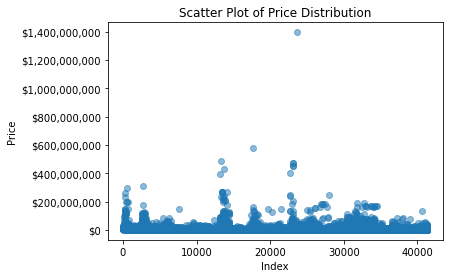

In [13]:
# Select the 'price' column
price_values = df.select('price').rdd.flatMap(lambda x: x).collect()

# Create a scatter plot
plt.scatter(range(len(price_values)), price_values, alpha=0.5)
plt.title('Scatter Plot of Price Distribution')
plt.xlabel('Index')
plt.ylabel('Price')

# Format y-axis ticks as normal price values
def format_price_ticks(value, pos):
    return f'${value:,.0f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_price_ticks))

plt.show()

- Most prices fall below $200,000,000

- There is an anomaly/outlier, where the price of the property is around $1,400,000,000

In [14]:
df.agg({'price':'avg'}).show()

+-----------------+
|       avg(price)|
+-----------------+
|6610496.336532882|
+-----------------+



### Step 2: `Exploratory Data Analysis and Data Cleansing` <a id="part2"></a>

Examining data, and flag out any interesting trends, anomalies, or potential errors. 
- Statistical and Visualisation Approaches
- Grouping and Filtering 
- Drop Unnecessary Columns 
- Missing Value Treatment 

### Numerical Data

In [15]:
# data types
df.dtypes

[('sub_property_type', 'string'),
 ('living_space', 'double'),
 ('bathroom_number', 'int'),
 ('currency', 'string'),
 ('property_type', 'string'),
 ('property_id', 'int'),
 ('city', 'string'),
 ('floor_level', 'int'),
 ('state', 'string'),
 ('built_year', 'int'),
 ('latitude', 'double'),
 ('premium', 'int'),
 ('bedroom_number', 'int'),
 ('address', 'string'),
 ('listing_label', 'string'),
 ('longitude', 'double'),
 ('tenure', 'string'),
 ('price', 'int')]

In [16]:
#Using groupBy to inspect the average of price for each category, in descending order of avg price

df.groupBy('premium').avg('price').orderBy(spark_col('avg(price)').desc()).show()

# The average price shows that premium houses are more expensive than non-premium houses.
# Not surprising as premium houses tend to mean better facilities/place, and 'superior' compared to non premium.

+-------+------------------+
|premium|        avg(price)|
+-------+------------------+
|      1| 6971732.534923339|
|      0|6605295.6976675745|
+-------+------------------+



#### Checking for anomalies/outliers

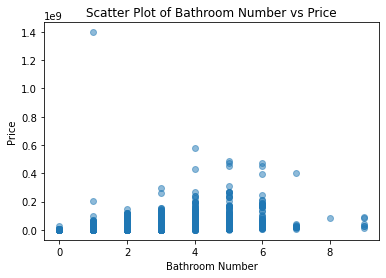

In [17]:
# Select the desired columns
data = df.select('bathroom_number', 'price').collect()

# Extract data from Row objects
bathroom_number = [row['bathroom_number'] for row in data]
price = [row['price'] for row in data]

# Create a scatter plot
plt.scatter(bathroom_number, price, alpha=0.5)
plt.title('Scatter Plot of Bathroom Number vs Price')
plt.xlabel('Bathroom Number')
plt.ylabel('Price')

plt.show()

Excluding the price anomaly, it seems that houses with 4 or 5 are more expensive that the rest. It shows a normal distribution.

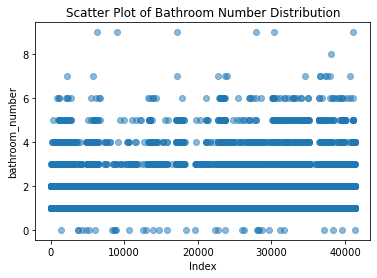

In [18]:
#Bathroom number distribution

feature = df.select('bathroom_number').rdd.flatMap(lambda x: x).collect()

# Create a scatter plot
plt.scatter(range(len(feature)), feature, alpha=0.5)
plt.title('Scatter Plot of Bathroom Number Distribution')
plt.xlabel('Index')
plt.ylabel('bathroom_number')

plt.show()

Most of the houses have around 1-2 bathrooms. There are a few with above 8 bathroom numbers.

There are no anomalies or outliers here.

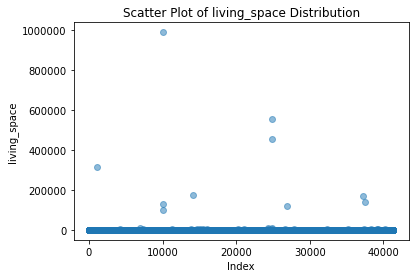

In [19]:
#living_space distribution

feature = df.select('living_space').rdd.flatMap(lambda x: x).collect()

# Create a scatter plot
plt.scatter(range(len(feature)), feature, alpha=0.5)
plt.title('Scatter Plot of living_space Distribution')
plt.xlabel('Index')
plt.ylabel('living_space')

plt.ticklabel_format(style='plain', axis='y')

plt.show()

There is quite a handful of outliers, especially one going up to 989898.0. They may need to be handled.

In [20]:
df.agg({'living_space':'avg'}).show()

+-----------------+
|avg(living_space)|
+-----------------+
|131.2979258121521|
+-----------------+



In [21]:
df.describe(['living_space']).show()

+-------+-----------------+
|summary|     living_space|
+-------+-----------------+
|  count|            41310|
|   mean|131.2979258121521|
| stddev|6444.044353131916|
|    min|             16.0|
|    max|         989898.0|
+-------+-----------------+



The large standard deviation of 6444.04 indicates that the 'living_space' values are widely spread out from the mean.

The majority of 'living_space' values are likely clustered around the mean of 131.30.

The large standard deviation suggests a wide range of living space sizes, with some values significantly deviating from the mean.

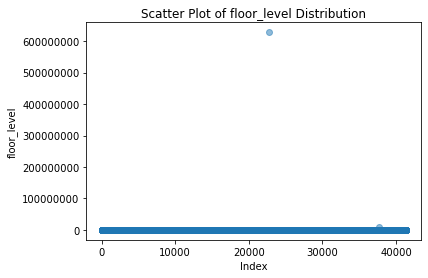

In [22]:
#floor_level distribution

feature = df.select('floor_level').rdd.flatMap(lambda x: x).collect()

# Create a scatter plot
plt.scatter(range(len(feature)), feature, alpha=0.5)
plt.title('Scatter Plot of floor_level Distribution')
plt.xlabel('Index')
plt.ylabel('floor_level')

plt.ticklabel_format(style='plain', axis='y')

plt.show()


Very clear that theres an anomaly that needs to be handled, it is impossible for floor level to be that high.

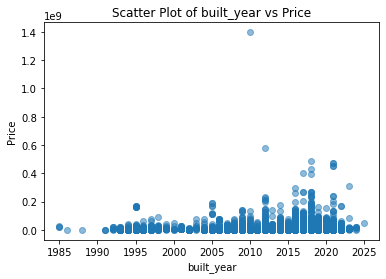

In [23]:
# Select the desired columns
data = df.select('built_year', 'price').collect()

# Extract data from Row objects
value = [row['built_year'] for row in data]
price = [row['price'] for row in data]

# Create a scatter plot
plt.scatter(value, price, alpha=0.5)
plt.title('Scatter Plot of built_year vs Price')
plt.xlabel('built_year')
plt.ylabel('Price')

plt.show()

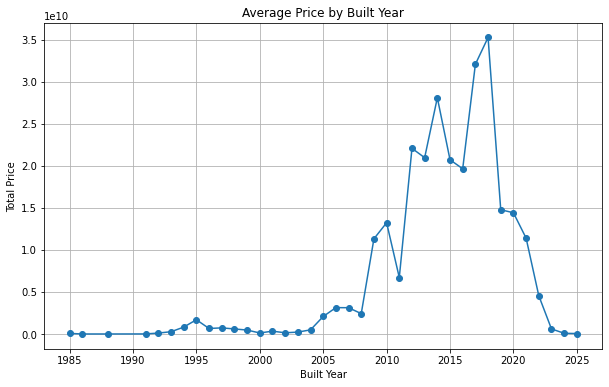

In [24]:
price = df.groupBy('built_year').sum('price').orderBy('built_year')

# Extract data for plotting
years = [row['built_year'] for row in price.collect()]
prices = [row['sum(price)'] for row in price.collect()]

# Create a line chart using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(years, prices, marker='o', linestyle='-')
plt.title('Average Price by Built Year')
plt.xlabel('Built Year')
plt.ylabel('Total Price')
plt.grid(True)
plt.show()

Excluding the price outlier, it is notable that the prices increase as the year goes by. The price seems to be quite high around 2018. The price increase may be due to inflation or possibly houses increasing in quality (hence the increase in price because of demand). 

However, it is interesting that prices for 2022-2025 dropped.

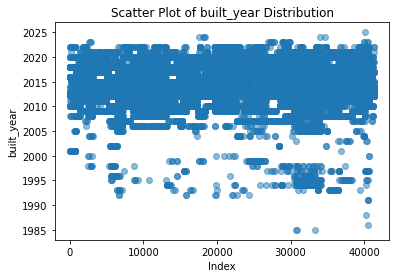

In [25]:
#built_year' distribution

feature = df.select('built_year').rdd.flatMap(lambda x: x).collect()

# Create a scatter plot
plt.scatter(range(len(feature)), feature, alpha=0.5)
plt.title('Scatter Plot of built_year Distribution')
plt.xlabel('Index')
plt.ylabel('built_year')

plt.ticklabel_format(style='plain', axis='y')

plt.show()

Can be seen that most of the houses are build around 2010-2021. There are a few houses under 2024 and 2025, this may indicate that those houses may still be in the process of being built.

It is interesting to note that there is a clutter of houses built around 1995 period.

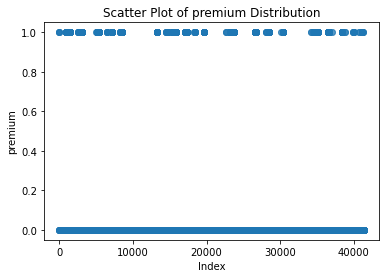

In [26]:
#premium distribution

feature = df.select('premium').rdd.flatMap(lambda x: x).collect()

# Create a scatter plot
plt.scatter(range(len(feature)), feature, alpha=0.5)
plt.title('Scatter Plot of premium Distribution')
plt.xlabel('Index')
plt.ylabel('premium')

plt.ticklabel_format(style='plain', axis='y')

plt.show()

There are more non-premium houses than premium ones.

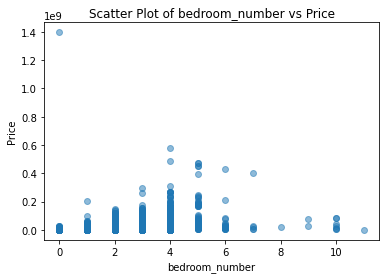

In [27]:
# Select the desired columns
data = df.select('bedroom_number', 'price').collect()

# Extract data from Row objects
value = [row['bedroom_number'] for row in data]
price = [row['price'] for row in data]

# Create a scatter plot
plt.scatter(value, price, alpha=0.5)
plt.title('Scatter Plot of bedroom_number vs Price')
plt.xlabel('bedroom_number')
plt.ylabel('Price')

plt.show()

It has a normal distribution like shape, where houses with 4 and 5 bedrooms have higher price compared to the rest. 

It is interesting that houses with higher number of bedrooms (7-11) dropped. However, this may be due to the demand. As most families tend to have around 4-5 people, the demand for houses with 4-5 rooms may be higher, causing the price to increase due to high demand. 

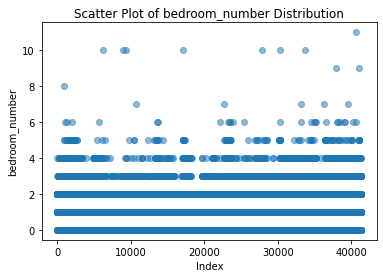

In [28]:
#bedroom_number distribution

feature = df.select('bedroom_number').rdd.flatMap(lambda x: x).collect()

# Create a scatter plot
plt.scatter(range(len(feature)), feature, alpha=0.5)
plt.title('Scatter Plot of bedroom_number Distribution')
plt.xlabel('Index')
plt.ylabel('bedroom_number')

plt.ticklabel_format(style='plain', axis='y')

plt.show()

Most houses seem to have around 0-3 bedrooms. There's one house with 11 rooms. This will not be considered an anomaly or outlier.

### Categorical Data

In [29]:
df.groupBy("property_type", "sub_property_type")\
                                .agg(count("*").alias("count"))\
                                .orderBy("property_type", "sub_property_type").show()

+--------------+-----------------+-----+
| property_type|sub_property_type|count|
+--------------+-----------------+-----+
|     Apartment|         For Sale|    4|
|         Condo|         For Sale|39636|
|         Condo|    Option To Buy|  234|
|Detached House|         For Sale|  835|
|     Townhouse|         For Sale|  651|
+--------------+-----------------+-----+



Apartment, Detached House, and Townhouse are all For Sale. Only Condo houses have the option of For Sale or Option To Buy.

Apartment is the least common house, with only 4, compared to Condo (For Sale), which has 39k+.

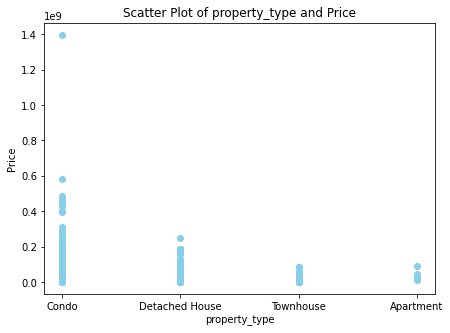

In [30]:
data = df.select("property_type", "price").collect()

# Extracting data for plotting
room_types = [row['property_type'] for row in data]
prices = [row['price'] for row in data]

# Plotting using Matplotlib
plt.figure(figsize=(7, 5))
plt.scatter(room_types, prices, color='skyblue')
plt.title('Scatter Plot of property_type and Price')
plt.xlabel('property_type')
plt.ylabel('Price')
plt.show()

Most of the houses are Condos. 

The price of Condos tend to be more expensive than the rest, with Apartment being the cheapest.

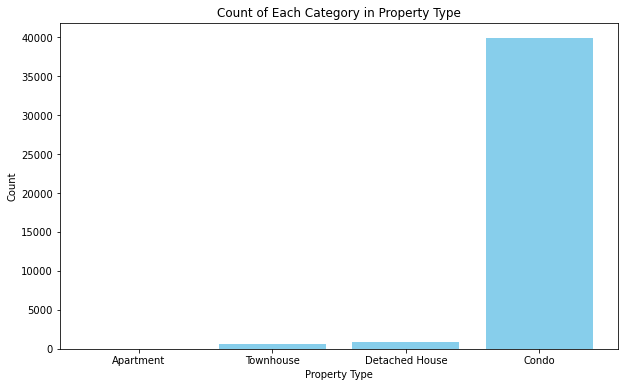

In [31]:
# Grouping and counting the occurrences of each category
counts = df.groupBy("property_type").count().orderBy("count")

# Collect the result to the driver
result_collected = counts.collect()

# Extracting data for plotting
property_types = [row['property_type'] for row in result_collected]
counts = [row['count'] for row in result_collected]

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(property_types, counts, color='skyblue')
plt.title('Count of Each Category in Property Type')
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.show()

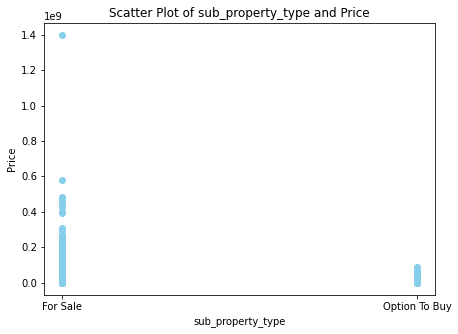

In [32]:
data = df.select("sub_property_type", "price").collect()

# Extracting data for plotting
room_types = [row['sub_property_type'] for row in data]
prices = [row['price'] for row in data]

# Plotting using Matplotlib
plt.figure(figsize=(7, 5))
plt.scatter(room_types, prices, color='skyblue')
plt.title('Scatter Plot of sub_property_type and Price')
plt.xlabel('sub_property_type')
plt.ylabel('Price')
plt.show()

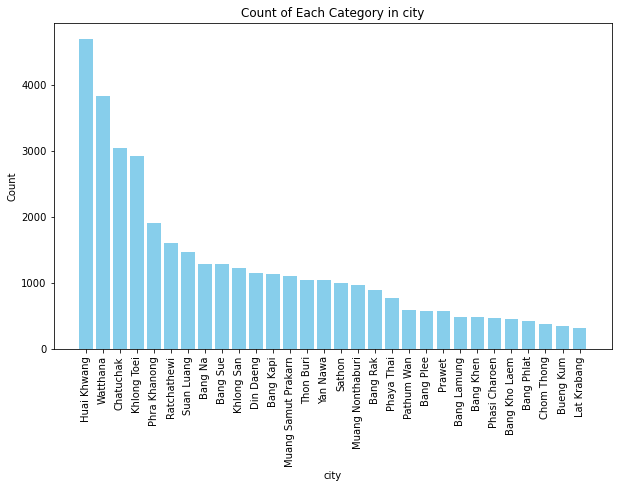

In [33]:
# Grouping and counting the occurrences of each category
counts = df.groupBy("city").count().orderBy("count", ascending=False)

# Limit to the top 10 cities
top_counts = counts.limit(30)

# Collect the result to the driver
result_collected = top_counts.collect()

# Extracting data for plotting
property_types = [row['city'] for row in result_collected]
counts = [row['count'] for row in result_collected]

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(property_types, counts, color='skyblue')
plt.title('Count of Each Category in city')
# Rotate x-axis labels vertically
plt.xticks(rotation='vertical')
plt.xlabel('city')
plt.ylabel('Count')
plt.show()

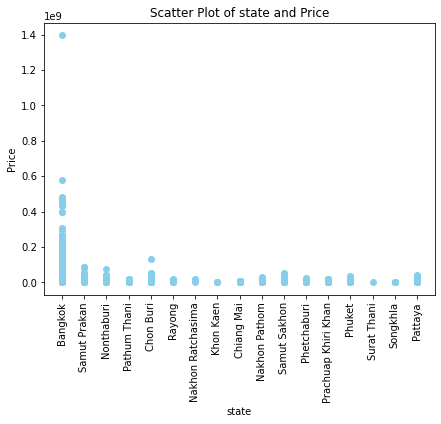

In [34]:
data = df.select("state", "price").collect()

# Extracting data for plotting
room_types = [row['state'] for row in data]
prices = [row['price'] for row in data]

# Plotting using Matplotlib
plt.figure(figsize=(7, 5))
plt.scatter(room_types, prices, color='skyblue')
plt.title('Scatter Plot of state and Price')
plt.xticks(rotation='vertical')
plt.xlabel('state')
plt.ylabel('Price')
plt.show()

It seems Bangkok have significantly higher house prices compared to the rest of the states. This is not surprising as Bangkok is the capital of Thailand. Capitals are either also the financial center or the cultural center of a country or region. Therefore, prices there are expected to be higher.

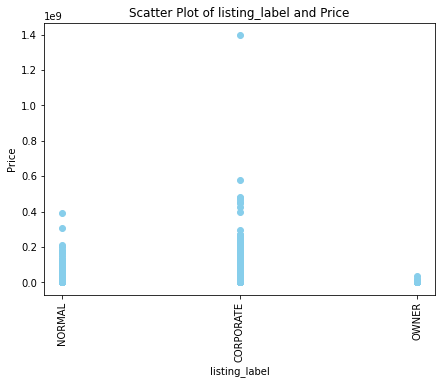

In [35]:
data = df.select("listing_label", "price").collect()

# Extracting data for plotting
room_types = [row['listing_label'] for row in data]
prices = [row['price'] for row in data]

# Plotting using Matplotlib
plt.figure(figsize=(7, 5))
plt.scatter(room_types, prices, color='skyblue')
plt.title('Scatter Plot of listing_label and Price')
plt.xticks(rotation='vertical')
plt.xlabel('listing_label')
plt.ylabel('Price')
plt.show()

It can be noticed that Corporate seems to be more expensive, and Owner is the cheapest.

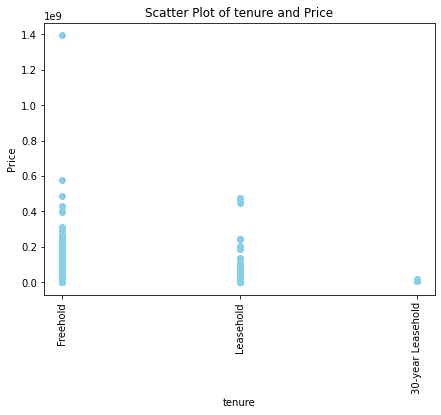

In [36]:
data = df.select("tenure", "price").collect()

# Extracting data for plotting
room_types = [row['tenure'] for row in data]
prices = [row['price'] for row in data]

# Plotting using Matplotlib
plt.figure(figsize=(7, 5))
plt.scatter(room_types, prices, color='skyblue')
plt.title('Scatter Plot of tenure and Price')
plt.xticks(rotation='vertical')
plt.xlabel('tenure')
plt.ylabel('Price')
plt.show()

Freehold and Leasehold prices looks about the same. However, 30-year Leasehold have significantly fewer houses and cheaper as well.

### Dropping Unnecessary Columns 

In [37]:
df.dtypes

[('sub_property_type', 'string'),
 ('living_space', 'double'),
 ('bathroom_number', 'int'),
 ('currency', 'string'),
 ('property_type', 'string'),
 ('property_id', 'int'),
 ('city', 'string'),
 ('floor_level', 'int'),
 ('state', 'string'),
 ('built_year', 'int'),
 ('latitude', 'double'),
 ('premium', 'int'),
 ('bedroom_number', 'int'),
 ('address', 'string'),
 ('listing_label', 'string'),
 ('longitude', 'double'),
 ('tenure', 'string'),
 ('price', 'int')]

In [38]:
df.show(5)

+-----------------+------------+---------------+--------+--------------+-----------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+-------+
|sub_property_type|living_space|bathroom_number|currency| property_type|property_id|     city|floor_level|  state|built_year|   latitude|premium|bedroom_number|             address|listing_label|  longitude|  tenure|  price|
+-----------------+------------+---------------+--------+--------------+-----------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+-------+
|         For Sale|       76.86|              2|    Baht|         Condo|    9942777|    Dusit|          6|Bangkok|      2010|13.79101869|      0|             2|Samsen Road, Dusi...|       NORMAL|100.5162452|Freehold|5500000|
|         For Sale|        42.0|              1|    Baht|         Condo|    9807686|    Dusit|      

In [39]:
df_dropped = df.drop('property_id','currency','latitude','longitude','address')
df_dropped.show(5)

#Property_id dropped because unique identifiers are not meaningful
#Currency dropped because all the currency is the same, making it unnecessary
#Latitude and Longitude are geographical areas, not significant in modelling

+-----------------+------------+---------------+--------------+---------+-----------+-------+----------+-------+--------------+-------------+--------+-------+
|sub_property_type|living_space|bathroom_number| property_type|     city|floor_level|  state|built_year|premium|bedroom_number|listing_label|  tenure|  price|
+-----------------+------------+---------------+--------------+---------+-----------+-------+----------+-------+--------------+-------------+--------+-------+
|         For Sale|       76.86|              2|         Condo|    Dusit|          6|Bangkok|      2010|      0|             2|       NORMAL|Freehold|5500000|
|         For Sale|        42.0|              1|         Condo|    Dusit|          4|Bangkok|      2010|      0|             1|       NORMAL|Freehold|4100000|
|         For Sale|       123.0|              2|Detached House|Nong Chok|          2|Bangkok|      2012|      0|             3|    CORPORATE|Freehold|1650000|
|         For Sale|       180.0|              

### Missing Value Treatment 

In [40]:
#show null count BEFORE IMPUTATION
from pyspark.sql.functions import col, isnan, when, count

df_dropped.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_dropped.columns]).show()

#only living space has null values

+-----------------+------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+-------------+------+-----+
|sub_property_type|living_space|bathroom_number|property_type|city|floor_level|state|built_year|premium|bedroom_number|listing_label|tenure|price|
+-----------------+------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+-------------+------+-----+
|                0|          50|              0|            0|   0|          0|    0|         0|      0|             0|            0|     0|    0|
+-----------------+------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+-------------+------+-----+



In [41]:
# Filter out null values in "living_space"
filtered_df = df.filter(col('living_space').isNotNull())

# Calculate mean and median of "living_space" in the filtered DataFrame
mean_living_space = filtered_df.agg({"living_space": "mean"}).collect()[0]["avg(living_space)"]
median_living_space = filtered_df.approxQuantile("living_space", [0.5], 0.001)[0]

# Print the results
print(f"Mean Living Space (excluding null values): {mean_living_space}")
print(f"Median Living Space (excluding null values): {median_living_space}")

#Decided to impute using mean

Mean Living Space (excluding null values): 131.2979258121521
Median Living Space (excluding null values): 35.0


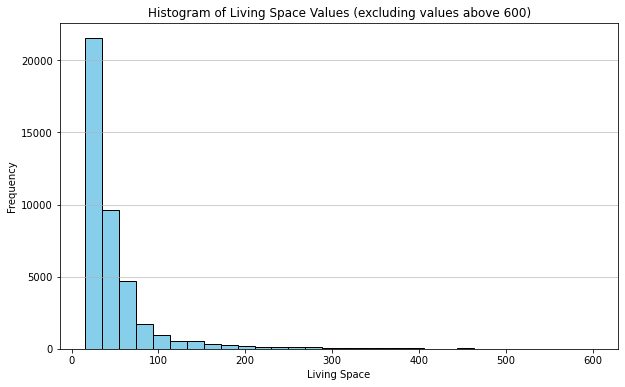

In [42]:
#BEFORE IMPUTATION
# Filter out values above 1000 in "living_space" to see the distribution clearer
filtered_df = df.filter(col('living_space') <= 600)

# Extract "living_space" values for plotting
living_space_values = filtered_df.select('living_space').rdd.flatMap(lambda x: x).collect()

# Create a histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(living_space_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Living Space Values (excluding values above 600)')
plt.xlabel('Living Space')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# can be seen that the distribution is very positively skewed

As the distribution of "living_space" is heavily right skewed and has outliers, median will be used so that the distribution stays the same.

The median is less sensitive to extreme values, making it a robust measure of central tendency.

#### Imputing missing values by Median

In [43]:
imputer = Imputer(
    inputCols=['living_space'], 
    outputCols=["{}".format(c) for c in ['living_space']]
    ).setStrategy("median")

In [44]:
# Add imputation cols to df
df_imputed = imputer.fit(df_dropped).transform(df_dropped)

In [45]:
#Check for null values AFTER IMPUTATION
df_imputed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_imputed.columns]).show()

+-----------------+------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+-------------+------+-----+
|sub_property_type|living_space|bathroom_number|property_type|city|floor_level|state|built_year|premium|bedroom_number|listing_label|tenure|price|
+-----------------+------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+-------------+------+-----+
|                0|           0|              0|            0|   0|          0|    0|         0|      0|             0|            0|     0|    0|
+-----------------+------------+---------------+-------------+----+-----------+-----+----------+-------+--------------+-------------+------+-----+



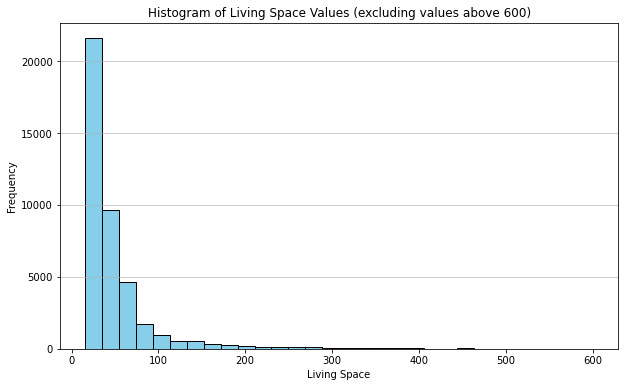

In [46]:
# Filter out values above 1000 in "living_space" to see the distribution clearer
filtered_df = df_imputed.filter(col('living_space') <= 600)

# Extract "living_space" values for plotting
living_space_values = filtered_df.select('living_space').rdd.flatMap(lambda x: x).collect()

# Create a histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(living_space_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Living Space Values (excluding values above 600)')
plt.xlabel('Living Space')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# can be seen that the distribution is very positively skewed

This ensures that the original shape is kept, and makes the distribution less skewed.

After imputing, we need to fix the outliers as well.

### Step 3: `Data Wrangling and Transformation` <a id="part3"></a>

Wrangle and/or transform the tabular data before feeding it into the Machine Learning portion 
of your Predictive Model.
- Feature Engineering
- Outlier Handling
- Categorical Data Encoding 
- Numerical Data Transformation 
- Feature Scaling  

In [47]:
df_imputed.dtypes

[('sub_property_type', 'string'),
 ('living_space', 'double'),
 ('bathroom_number', 'int'),
 ('property_type', 'string'),
 ('city', 'string'),
 ('floor_level', 'int'),
 ('state', 'string'),
 ('built_year', 'int'),
 ('premium', 'int'),
 ('bedroom_number', 'int'),
 ('listing_label', 'string'),
 ('tenure', 'string'),
 ('price', 'int')]

### Feature Engineering

In [48]:
current_year = F.year(F.current_date())
df_eng = df_imputed.withColumn("property_age", current_year - col("built_year"))

#However, as some built_year are in 2024 and 2025, there will be some negative values, and we need to convert them to 0.
df_eng = df_eng.withColumn("property_age", F.when(col("property_age") < 0, 0).otherwise(col("property_age")))

In [49]:
#Check that there are no negative values
df_eng.filter(col("property_age") < 0).count()

0

### Outlier Handling

From EDA, the features where the outliers needs to be handled are price, living_space, floor_level.

In [50]:
df_eng.dtypes

[('sub_property_type', 'string'),
 ('living_space', 'double'),
 ('bathroom_number', 'int'),
 ('property_type', 'string'),
 ('city', 'string'),
 ('floor_level', 'int'),
 ('state', 'string'),
 ('built_year', 'int'),
 ('premium', 'int'),
 ('bedroom_number', 'int'),
 ('listing_label', 'string'),
 ('tenure', 'string'),
 ('price', 'int'),
 ('property_age', 'int')]

In [51]:
outl = ['price', 'living_space', 'floor_level']

In [52]:
# Function to create diagnostic plots
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 3, 1)
    plt.hist(df.select(variable).rdd.flatMap(lambda x: x).collect(), bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df.select(variable).rdd.flatMap(lambda x: x).collect(), dist="norm", plot=plt)
    plt.ylabel(f'{variable} quantiles')

    # Boxplot
    plt.subplot(1, 3, 3)
    plt.boxplot(df.select(variable).rdd.flatMap(lambda x: x).collect())
    plt.title('Boxplot')

    plt.show()


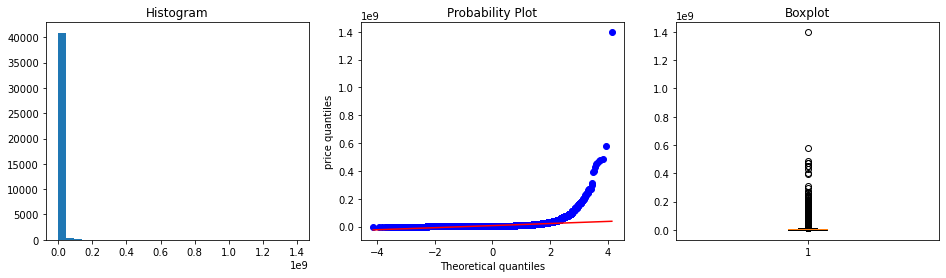

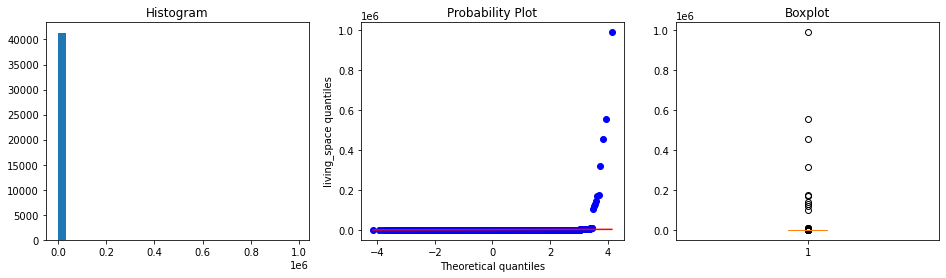

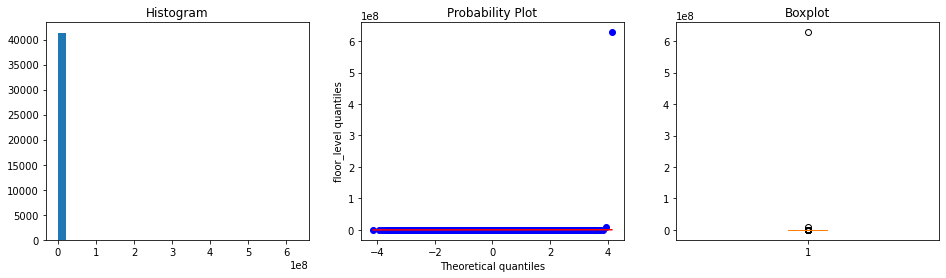

In [53]:
for feature in outl:
    diagnostic_plots(df_eng, feature)

#### Trimming

Trimming involves removing extreme values (outliers) from a dataset. It reduces the impact of extreme values on mean and standard deviation, addressing skewness-related distortions in modeling (in this case, it is very positively skewed).

In [54]:
def find_boundaries(df, variable, distance):
    # Calculate quantiles using approxQuantile
    quantiles = df.approxQuantile(variable, [0.25, 0.75], 0.01)  # Use a low relativeError for higher accuracy

    # Extract quantile values
    Q1 = quantiles[0]
    Q3 = quantiles[1]

    # Calculate IQR and boundaries
    IQR = Q3 - Q1
    lower_boundary = Q1 - (IQR * distance)
    upper_boundary = Q3 + (IQR * distance)

    return upper_boundary, lower_boundary

In [55]:
# find limits for train and test

price_upper_limit, price_lower_limit = find_boundaries(df_eng, 'price', 1.5)
print(f"Upper Boundary for price: {price_upper_limit}")
print(f"Lower Boundary for price: {price_lower_limit}")

Upper Boundary for price: 12690000.0
Lower Boundary for price: -4110000.0


In [56]:
# Find limits for 'living_space' in both train and test

ls_upper_limit, ls_lower_limit = find_boundaries(df_eng, 'living_space', 1.5)

print(f"Upper Boundary for living_space: {ls_upper_limit}")
print(f"Lower Boundary for living_space: {ls_lower_limit}")

Upper Boundary for living_space: 87.815
Lower Boundary for living_space: -5.024999999999999


In [57]:
# Find limits for 'floor_level' in both train and test

fl_upper_limit, fl_lower_limit = find_boundaries(df_eng, 'floor_level', 1.5)

print(f"Upper Boundary for floor_level: {fl_upper_limit}")
print(f"Lower Boundary for floor_level: {fl_lower_limit}")

Upper Boundary for floor_level: 53.5
Lower Boundary for floor_level: -22.5


In [58]:
# Trim the training dataset
df_trimmed = df_eng.filter(
    (col("price") >= price_lower_limit) & (col("price") <= price_upper_limit) &
    (col("floor_level") >= fl_lower_limit) & (col("floor_level") <= fl_upper_limit) &
    (col("living_space") >= ls_lower_limit) & (col("living_space") <= ls_upper_limit)
)

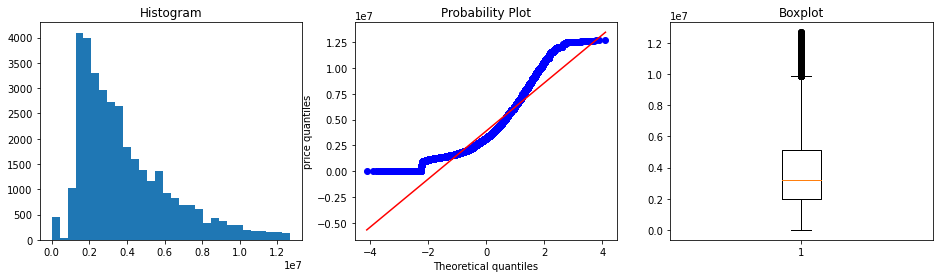

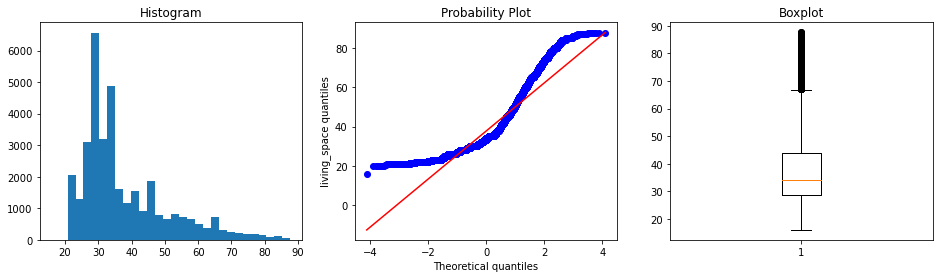

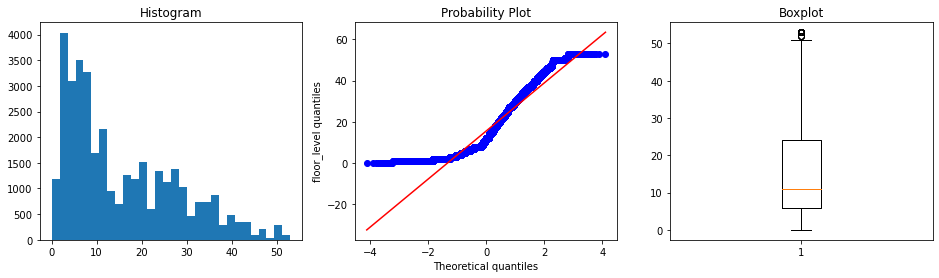

In [59]:
for feature in outl:
    diagnostic_plots(df_trimmed, feature)

Probability plot became steeper and more points fall on the best fit line, proving that it is successful in outlier handling for better model.

In [60]:
#Number of rows before and after
df_eng.count(), df_trimmed.count()

(41360, 35007)

### Transforming Categorical Features

In [61]:
df_trimmed.dtypes

[('sub_property_type', 'string'),
 ('living_space', 'double'),
 ('bathroom_number', 'int'),
 ('property_type', 'string'),
 ('city', 'string'),
 ('floor_level', 'int'),
 ('state', 'string'),
 ('built_year', 'int'),
 ('premium', 'int'),
 ('bedroom_number', 'int'),
 ('listing_label', 'string'),
 ('tenure', 'string'),
 ('price', 'int'),
 ('property_age', 'int')]

In [62]:
df_trimmed.groupBy("sub_property_type").count().show()

+-----------------+-----+
|sub_property_type|count|
+-----------------+-----+
|         For Sale|34850|
|    Option To Buy|  157|
+-----------------+-----+



In [63]:
df_trimmed.groupBy("property_type").count().show()

+--------------+-----+
| property_type|count|
+--------------+-----+
|     Townhouse|   43|
|         Condo|34947|
|Detached House|   17|
+--------------+-----+



In [64]:
df_trimmed.select("city").distinct().count()

81

In [65]:
df_trimmed.select("state").distinct().count() 

16

In [66]:
df_trimmed.groupBy("listing_label").count().show()

+-------------+-----+
|listing_label|count|
+-------------+-----+
|        OWNER|   11|
|    CORPORATE|32528|
|       NORMAL| 2468|
+-------------+-----+



In [67]:
df_trimmed.groupBy("tenure").count().show()

+-----------------+-----+
|           tenure|count|
+-----------------+-----+
|30-year Leasehold|    1|
|         Freehold|34924|
|        Leasehold|   82|
+-----------------+-----+



#### PySpark OHE

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [68]:
#Before
df_trimmed.show(1)

+-----------------+------------+---------------+-------------+-----+-----------+-------+----------+-------+--------------+-------------+--------+-------+------------+
|sub_property_type|living_space|bathroom_number|property_type| city|floor_level|  state|built_year|premium|bedroom_number|listing_label|  tenure|  price|property_age|
+-----------------+------------+---------------+-------------+-----+-----------+-------+----------+-------+--------------+-------------+--------+-------+------------+
|         For Sale|       76.86|              2|        Condo|Dusit|          6|Bangkok|      2010|      0|             2|       NORMAL|Freehold|5500000|          13|
+-----------------+------------+---------------+-------------+-----+-----------+-------+----------+-------+--------------+-------------+--------+-------+------------+
only showing top 1 row



In [69]:
# Define columns to be used in the pipeline
strings_used = ["sub_property_type", "property_type", "city", "state", "listing_label", "tenure"]

# Create StringIndexer and OneHotEncoder stages for the pipeline
stage_string = [StringIndexer(inputCol=c, outputCol=c + "_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol=c + "_string_encoded", outputCol=c + "_one_hot") for c in strings_used]

# Create a pipeline for categorical feature transformation
pp = Pipeline(stages= stage_string + stage_one_hot)

df_ohe = pp.fit(df_trimmed).transform(df_trimmed)

Pipeline is used for OHE. OHE transforms categorical variables into a binary vector representation, allowing models to process and learn from categorical information effectively.

In [70]:
selected_columns = ['built_year', 'premium','sub_property_type_one_hot','property_type_one_hot', 'city_one_hot',
                   'state_one_hot','listing_label_one_hot','tenure_one_hot','living_space','bathroom_number',
                   'floor_level','bedroom_number','property_age','price']

df_ohe = df_ohe.select(selected_columns)

In [71]:
# After
df_ohe.show(3)

+----------+-------+-------------------------+---------------------+---------------+--------------+---------------------+--------------+------------+---------------+-----------+--------------+------------+--------+
|built_year|premium|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|listing_label_one_hot|tenure_one_hot|living_space|bathroom_number|floor_level|bedroom_number|property_age|   price|
+----------+-------+-------------------------+---------------------+---------------+--------------+---------------------+--------------+------------+---------------+-----------+--------------+------------+--------+
|      2010|      0|            (1,[0],[1.0])|        (2,[0],[1.0])|(80,[70],[1.0])|(15,[0],[1.0])|        (2,[1],[1.0])| (2,[0],[1.0])|       76.86|              2|          6|             2|          13| 5500000|
|      2010|      0|            (1,[0],[1.0])|        (2,[0],[1.0])|(80,[70],[1.0])|(15,[0],[1.0])|        (2,[1],[1.0])| (2,[0],[1.0])|    

### Train Test Split

In [72]:
(train, test) = df_ohe.randomSplit([0.8, 0.2], seed=42)

print((train.count(), len(train.columns)))
print((test.count(), len(test.columns)))

(28101, 14)
(6906, 14)


In [73]:
train.show(1)

+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------+---------------+-----------+--------------+------------+-------+
|built_year|premium|sub_property_type_one_hot|property_type_one_hot|  city_one_hot| state_one_hot|listing_label_one_hot|tenure_one_hot|living_space|bathroom_number|floor_level|bedroom_number|property_age|  price|
+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------+---------------+-----------+--------------+------------+-------+
|      1992|      0|            (1,[0],[1.0])|        (2,[0],[1.0])|(80,[1],[1.0])|(15,[0],[1.0])|        (2,[0],[1.0])| (2,[0],[1.0])|        50.0|              1|         12|             1|          31|3500000|
+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------+

In [74]:
test.show(1)

+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------+---------------+-----------+--------------+------------+-------+
|built_year|premium|sub_property_type_one_hot|property_type_one_hot|  city_one_hot| state_one_hot|listing_label_one_hot|tenure_one_hot|living_space|bathroom_number|floor_level|bedroom_number|property_age|  price|
+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------+---------------+-----------+--------------+------------+-------+
|      1993|      0|            (1,[0],[1.0])|        (2,[0],[1.0])|(80,[9],[1.0])|(15,[0],[1.0])|        (2,[0],[1.0])| (2,[0],[1.0])|        38.0|              1|         17|             0|          30|1550000|
+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------+

### Transforming Numerical Features

In [75]:
# ONLY TRANSFORMING CONTINUOUS
num = ['living_space', 'property_age' ]

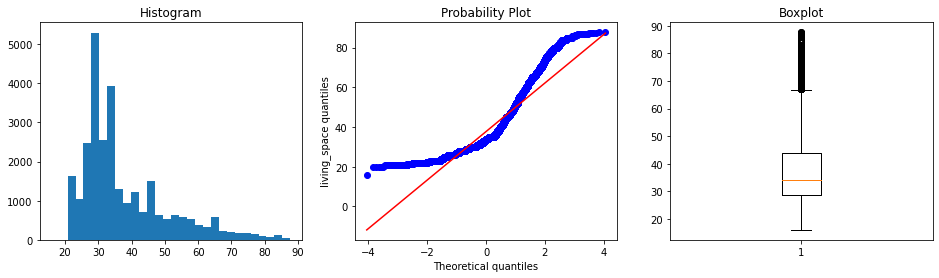

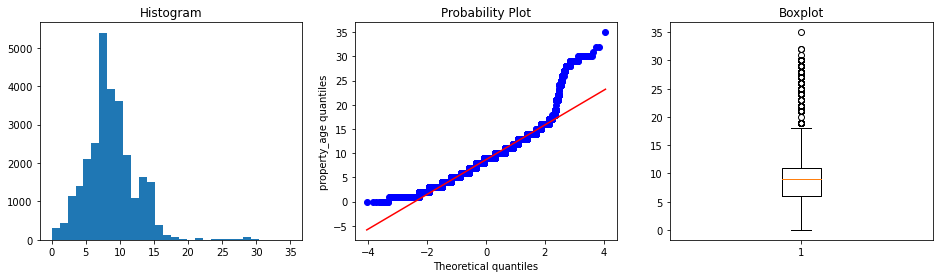

In [76]:
for feature in num:
    diagnostic_plots(train, feature)

#### Log Transformation
features with outliers, robust transformations like the log-transformation or Box-Cox can be more suitable as they are less influenced by extreme values.

Log transformation is suitable for positively skewed distributions, as it will make it less skewed.

-log1p function is used instead of log to avoid issues with log-transforming zero or negative values.

In [77]:
# Define the numerical features
numerical_features = ["living_space", "property_age"]

# Create a VectorAssembler to assemble numerical features into a vector
assembler = VectorAssembler(inputCols=numerical_features, outputCol="numerical_features")

# Define a custom SQL transformation to apply log transformation to each numerical feature individually
log_transformer = SQLTransformer(
    statement="SELECT *, " +
              "LOG1P(living_space) AS log_living_space, " +
              "LOG1P(property_age) AS log_property_age " +
              "FROM __THIS__"
)

# Create a pipeline with numerical features and log transformation
pipeline = Pipeline(stages=[assembler, log_transformer])

# Fit and transform the training and testing data using the numerical transformation pipeline
train_transformed = pipeline.fit(train).transform(train)
test_transformed = pipeline.fit(test).transform(test)

# Show the transformed data for training
train_transformed.show(truncate=False)

# Show the transformed data for testing
test_transformed.show(truncate=False)

+----------+-------+-------------------------+---------------------+---------------+--------------+---------------------+--------------+------------+---------------+-----------+--------------+------------+-------+------------------+------------------+------------------+
|built_year|premium|sub_property_type_one_hot|property_type_one_hot|city_one_hot   |state_one_hot |listing_label_one_hot|tenure_one_hot|living_space|bathroom_number|floor_level|bedroom_number|property_age|price  |numerical_features|log_living_space  |log_property_age  |
+----------+-------+-------------------------+---------------------+---------------+--------------+---------------------+--------------+------------+---------------+-----------+--------------+------------+-------+------------------+------------------+------------------+
|1992      |0      |(1,[0],[1.0])            |(2,[0],[1.0])        |(80,[1],[1.0]) |(15,[0],[1.0])|(2,[0],[1.0])        |(2,[0],[1.0]) |50.0        |1              |12         |1         

In [78]:
train_num_columns = len(train_transformed.columns)
test_num_columns = len(test_transformed.columns)

print(f"Number of columns in train_data: {train_num_columns}")
print(f"Number of columns in test_data: {test_num_columns}")

Number of columns in train_data: 17
Number of columns in test_data: 17


In [79]:
num = ['log_living_space','log_property_age']

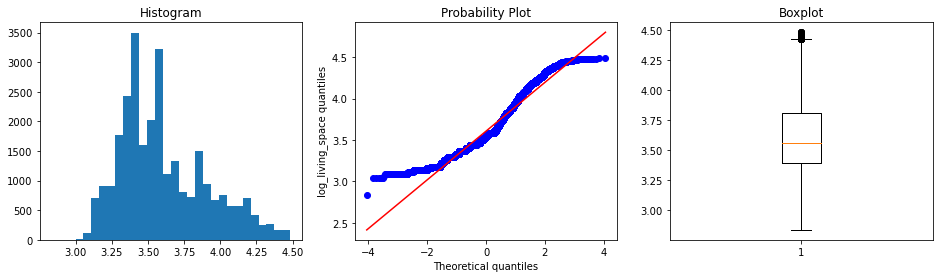

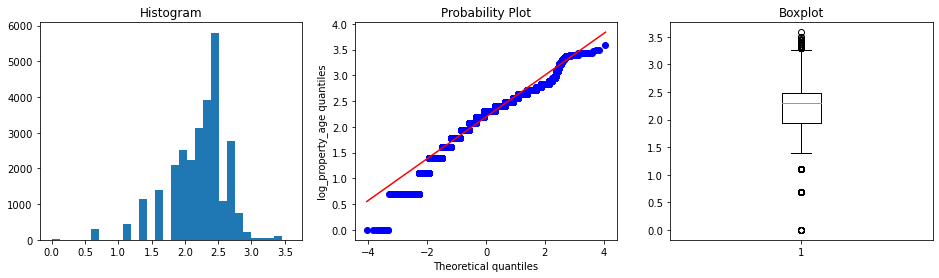

In [80]:
for feature in num:
    diagnostic_plots(train_transformed, feature)

In [81]:
train_transformed.dtypes, test_transformed.dtypes

([('built_year', 'int'),
  ('premium', 'int'),
  ('sub_property_type_one_hot', 'vector'),
  ('property_type_one_hot', 'vector'),
  ('city_one_hot', 'vector'),
  ('state_one_hot', 'vector'),
  ('listing_label_one_hot', 'vector'),
  ('tenure_one_hot', 'vector'),
  ('living_space', 'double'),
  ('bathroom_number', 'int'),
  ('floor_level', 'int'),
  ('bedroom_number', 'int'),
  ('property_age', 'int'),
  ('price', 'int'),
  ('numerical_features', 'vector'),
  ('log_living_space', 'double'),
  ('log_property_age', 'double')],
 [('built_year', 'int'),
  ('premium', 'int'),
  ('sub_property_type_one_hot', 'vector'),
  ('property_type_one_hot', 'vector'),
  ('city_one_hot', 'vector'),
  ('state_one_hot', 'vector'),
  ('listing_label_one_hot', 'vector'),
  ('tenure_one_hot', 'vector'),
  ('living_space', 'double'),
  ('bathroom_number', 'int'),
  ('floor_level', 'int'),
  ('bedroom_number', 'int'),
  ('property_age', 'int'),
  ('price', 'int'),
  ('numerical_features', 'vector'),
  ('log_livin

In [82]:
selected_columns = ['built_year', 'premium','sub_property_type_one_hot','property_type_one_hot', 'city_one_hot',
                   'state_one_hot','listing_label_one_hot','tenure_one_hot','log_living_space','bathroom_number',
                   'floor_level','bedroom_number','log_property_age','price']

# Select only the specified columns
train_final = train_transformed.select(selected_columns)
test_final = test_transformed.select(selected_columns)

In [83]:
train_num_columns = len(train_final.columns)
test_num_columns = len(test_final.columns)

print(f"Number of columns in train_data: {train_num_columns}")
print(f"Number of columns in test_data: {test_num_columns}")

Number of columns in train_data: 14
Number of columns in test_data: 14


In [84]:
train_final.show(1)

+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+
|built_year|premium|sub_property_type_one_hot|property_type_one_hot|  city_one_hot| state_one_hot|listing_label_one_hot|tenure_one_hot|  log_living_space|bathroom_number|floor_level|bedroom_number|  log_property_age|  price|
+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+
|      1992|      0|            (1,[0],[1.0])|        (2,[0],[1.0])|(80,[1],[1.0])|(15,[0],[1.0])|        (2,[0],[1.0])| (2,[0],[1.0])|3.9318256327243257|              1|         12|             1|3.4657359027997265|3500000|
+----------+-------+-------------------------+---------------------+--------------+--------------+--

In [85]:
test_final.show(1)

+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+
|built_year|premium|sub_property_type_one_hot|property_type_one_hot|  city_one_hot| state_one_hot|listing_label_one_hot|tenure_one_hot|  log_living_space|bathroom_number|floor_level|bedroom_number|  log_property_age|  price|
+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+
|      1993|      0|            (1,[0],[1.0])|        (2,[0],[1.0])|(80,[9],[1.0])|(15,[0],[1.0])|        (2,[0],[1.0])| (2,[0],[1.0])|3.6635616461296463|              1|         17|             0|3.4339872044851463|1550000|
+----------+-------+-------------------------+---------------------+--------------+--------------+--

### Consolidating X columns

In [86]:
featureassembler=VectorAssembler(inputCols=train_final.columns[:-1],outputCol="Xcols")

In [87]:
train_vectored = featureassembler.transform(train_final)
train_vectored.show(3)

+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+--------------------+
|built_year|premium|sub_property_type_one_hot|property_type_one_hot|  city_one_hot| state_one_hot|listing_label_one_hot|tenure_one_hot|  log_living_space|bathroom_number|floor_level|bedroom_number|  log_property_age|  price|               Xcols|
+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+--------------------+
|      1992|      0|            (1,[0],[1.0])|        (2,[0],[1.0])|(80,[1],[1.0])|(15,[0],[1.0])|        (2,[0],[1.0])| (2,[0],[1.0])|3.9318256327243257|              1|         12|             1|3.4657359027997265|3500000|(109,[0,2,3,6,85,...|
|      1993|    

In [88]:
test_vectored = featureassembler.transform(test_final)
test_vectored.show(3)

+----------+-------+-------------------------+---------------------+---------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+--------------------+
|built_year|premium|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|listing_label_one_hot|tenure_one_hot|  log_living_space|bathroom_number|floor_level|bedroom_number|  log_property_age|  price|               Xcols|
+----------+-------+-------------------------+---------------------+---------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+--------------------+
|      1993|      0|            (1,[0],[1.0])|        (2,[0],[1.0])| (80,[9],[1.0])|(15,[0],[1.0])|        (2,[0],[1.0])| (2,[0],[1.0])|3.6635616461296463|              1|         17|             0|3.4339872044851463|1550000|(109,[0,2,3,14,85...|
|      1993|

In [89]:
vector_size = len(train_vectored.select("Xcols").first()["Xcols"])
print("Vector Size:", vector_size)

Vector Size: 109


In [90]:

vector_size = len(test_vectored.select("Xcols").first()["Xcols"])
print("Vector Size:", vector_size)

Vector Size: 109


In [91]:
train_num_columns = len(train_vectored.columns)
test_num_columns = len(test_vectored.columns)

print(f"Number of columns in train_data: {train_num_columns}")
print(f"Number of columns in test_data: {test_num_columns}")

Number of columns in train_data: 15
Number of columns in test_data: 15


### Feature Scaling

#### Standard Scaling

In [92]:
sScaler = StandardScaler(withMean=True, withStd=True, inputCol="Xcols", outputCol="Xcols_sscaled")

In [93]:
train_sscaled = sScaler.fit(train_vectored).transform(train_vectored)
train_sscaled.show(2)

+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+--------------------+--------------------+
|built_year|premium|sub_property_type_one_hot|property_type_one_hot|  city_one_hot| state_one_hot|listing_label_one_hot|tenure_one_hot|  log_living_space|bathroom_number|floor_level|bedroom_number|  log_property_age|  price|               Xcols|       Xcols_sscaled|
+----------+-------+-------------------------+---------------------+--------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+--------------------+--------------------+
|      1992|      0|            (1,[0],[1.0])|        (2,[0],[1.0])|(80,[1],[1.0])|(15,[0],[1.0])|        (2,[0],[1.0])| (2,[0],[1.0])|3.9318256327243257|              1|         12|             1|3.

In [94]:
test_sscaled = sScaler.fit(test_vectored).transform(test_vectored)
test_sscaled.show(2)

+----------+-------+-------------------------+---------------------+---------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+--------------------+--------------------+
|built_year|premium|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|listing_label_one_hot|tenure_one_hot|  log_living_space|bathroom_number|floor_level|bedroom_number|  log_property_age|  price|               Xcols|       Xcols_sscaled|
+----------+-------+-------------------------+---------------------+---------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+--------------------+--------------------+
|      1993|      0|            (1,[0],[1.0])|        (2,[0],[1.0])| (80,[9],[1.0])|(15,[0],[1.0])|        (2,[0],[1.0])| (2,[0],[1.0])|3.6635616461296463|              1|         17|             

### Step 4: `Machine Learning Modelling` <a id="part4"></a>

In [95]:
# use code to show number of rows and columns,
# as well as a sample of 10 rows before heading into Machine Learning Modelling

In [96]:
train_num_rows = train_sscaled.count()
train_num_columns = len(train_sscaled.columns)

test_num_rows = test_sscaled.count()
test_num_columns = len(test_sscaled.columns)

print(f"Number of rows in train_data: {train_num_rows}")
print(f"Number of columns in train_data: {train_num_columns}")

print(f"Number of rows in test_data: {test_num_rows}")
print(f"Number of columns in test_data: {test_num_columns}")

Number of rows in train_data: 28101
Number of columns in train_data: 16
Number of rows in test_data: 6906
Number of columns in test_data: 16


### Final Tidy-up and Check before Modeling

In [97]:
train_sscaled.show(10)

+----------+-------+-------------------------+---------------------+---------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+--------------------+--------------------+
|built_year|premium|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|listing_label_one_hot|tenure_one_hot|  log_living_space|bathroom_number|floor_level|bedroom_number|  log_property_age|  price|               Xcols|       Xcols_sscaled|
+----------+-------+-------------------------+---------------------+---------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+--------------------+--------------------+
|      1992|      0|            (1,[0],[1.0])|        (2,[0],[1.0])| (80,[1],[1.0])|(15,[0],[1.0])|        (2,[0],[1.0])| (2,[0],[1.0])|3.9318256327243257|              1|         12|             

In [98]:
test_sscaled.show(10)

+----------+-------+-------------------------+---------------------+---------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+--------------------+--------------------+
|built_year|premium|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|listing_label_one_hot|tenure_one_hot|  log_living_space|bathroom_number|floor_level|bedroom_number|  log_property_age|  price|               Xcols|       Xcols_sscaled|
+----------+-------+-------------------------+---------------------+---------------+--------------+---------------------+--------------+------------------+---------------+-----------+--------------+------------------+-------+--------------------+--------------------+
|      1993|      0|            (1,[0],[1.0])|        (2,[0],[1.0])| (80,[9],[1.0])|(15,[0],[1.0])|        (2,[0],[1.0])| (2,[0],[1.0])|3.6635616461296463|              1|         17|             

In [99]:
train_data = train_sscaled.select("Xcols_sscaled","price")
train_data.show(3)

+--------------------+-------+
|       Xcols_sscaled|  price|
+--------------------+-------+
|[-6.0626017496177...|3500000|
|[-5.7908362498898...|1560000|
|[-5.7908362498898...|1550000|
+--------------------+-------+
only showing top 3 rows



In [100]:
test_data = test_sscaled.select("Xcols_sscaled","price")
test_data.show(3)

+--------------------+-------+
|       Xcols_sscaled|  price|
+--------------------+-------+
|[-5.8998643007387...|1550000|
|[-5.8998643007387...|3990000|
|[-5.8998643007387...|3990000|
+--------------------+-------+
only showing top 3 rows



### Applying Linear Regression Predictive Algorithm Model

In [101]:
regressor=LinearRegression(featuresCol="Xcols_sscaled", labelCol='price')
regressor=regressor.fit(train_data)

In [102]:
type(regressor)

pyspark.ml.regression.LinearRegressionModel

In [103]:
# Coefficients
regressor.coefficients

DenseVector([673173.9564, -27737.7181, 10444.9637, -122066.8517, -174191.7166, -99710.0826, -2048.4954, 416394.434, 317164.3749, -6606.5474, 338229.0416, -148587.5283, -150774.4599, -142908.0673, -46420.9305, -147110.6086, -65164.7327, -130494.6152, -79553.1116, 118049.6137, -80636.3442, 71128.1995, 28742.124, 309060.7863, -154482.5408, -83613.121, -94014.5687, -83420.506, -18349.9759, -24423.9622, -94486.3217, -97367.1067, -55965.1024, -77571.6533, -55467.6756, -107290.9951, 240944.6928, -11491.1274, -69375.2092, -75530.4079, -24726.376, -72684.5613, -68004.0145, -60704.7048, -41027.4846, -13233.2464, -56131.5414, -19802.8398, -30767.8841, -15796.499, -8568.2154, -3950.9383, -85498.2109, -42374.0438, -19776.7411, -4298.5764, 4600.5794, -2084.7873, -22338.0389, -30212.2394, -59155.8051, -11170.8977, -42633.4799, -21638.1155, -14106.3371, -4466.2016, -20440.9362, 10017.4707, -6155.0444, -11081.4158, -278.3894, -6059.5722, -6418.8456, -4260.2428, -11145.1385, -329.2816, -19958.9867, -129

In [104]:
# Intercept
regressor.intercept

3887764.0831299885

In [105]:
# first row values of Xcols_sscaled
train_data.take(1)

[Row(Xcols_sscaled=DenseVector([-6.0626, -0.1172, 0.0666, 0.0422, -0.0363, -0.3785, 3.3171, -0.287, -0.2624, -0.2322, -0.2, -0.198, -0.1937, -0.1933, -0.1826, -0.1772, -0.1737, -0.1733, -0.1633, -0.1486, -0.1473, -0.1458, -0.1444, -0.1277, -0.1133, -0.1117, -0.1107, -0.1103, -0.1075, -0.1103, -0.103, -0.0955, -0.0932, -0.0886, -0.0882, -0.0874, -0.0882, -0.0847, -0.0798, -0.0816, -0.072, -0.072, -0.0728, -0.0624, -0.057, -0.0548, -0.0544, -0.0528, -0.0426, -0.0426, -0.0426, -0.0435, -0.0368, -0.0338, -0.0348, -0.0316, -0.0338, -0.0304, -0.031, -0.0316, -0.0273, -0.0223, -0.0231, -0.0246, -0.0223, -0.0198, -0.0169, -0.0169, -0.0133, -0.0103, -0.0103, -0.0103, -0.0084, -0.0084, -0.0084, -0.0084, -0.0084, -0.0084, -0.006, -0.006, 0.0, -0.006, -0.006, -0.006, 0.0, 0.3646, -0.2126, -0.2009, -0.1223, -0.0932, -0.0663, -0.0463, -0.0466, -0.0321, -0.0338, -0.026, -0.0133, -0.0103, -0.0084, -0.006, 0.2763, -0.2757, 0.0474, -0.047, 1.0733, -0.3374, -0.2854, -0.1296, 3.0603]), price=3500000)]

### Applying Random Forest Predictive Algorithm Model

In [106]:
# Create a RandomForestRegressor
rf = RandomForestRegressor(featuresCol="Xcols_sscaled", labelCol="price")

# Train the model
model = rf.fit(train_data)

In [107]:
# Make predictions on the training data
train_predictions = model.transform(train_data)

# Make predictions on the testing data
test_predictions = model.transform(test_data)

### Step 5: `Model Evaluation and Selection` <a id="part5"></a>

In [108]:
train_pred_results=regressor.evaluate(train_data)

In [109]:
train_pred_results.predictions.show()

+--------------------+-------+------------------+
|       Xcols_sscaled|  price|        prediction|
+--------------------+-------+------------------+
|[-6.0626017496177...|3500000|1468519.0973102031|
|[-5.7908362498898...|1560000| 296081.5887855035|
|[-5.7908362498898...|1550000| 400758.7585757752|
|[-5.7908362498898...|1550000| 541050.2307748799|
|[-5.7908362498898...|3500000|1727233.9580529672|
|[-5.7908362498898...|3990000|1766244.9832110372|
|[-5.7908362498898...|8590000| 2908638.125079289|
|[-5.7908362498898...|7850000| 4387922.154037799|
|[-5.7908362498898...|1550000|1197247.3114965172|
|[-5.7908362498898...|1100000|1147377.6360924612|
|[-5.5190707501618...|2150000|  284551.036615883|
|[-5.5190707501618...|2150000| 895173.2451207619|
|[-5.5190707501618...|2350000| 1920189.639688511|
|[-5.5190707501618...|2700000|2805913.4497598256|
|[-5.5190707501618...|7000000|2948198.3561828365|
|[-5.5190707501618...|6990000|3540296.8644477613|
|[-5.5190707501618...|6990000| 3879531.424728249|


In [110]:
test_pred_results=regressor.evaluate(test_data)

In [111]:
test_pred_results.predictions.show()

+--------------------+-------+------------------+
|       Xcols_sscaled|  price|        prediction|
+--------------------+-------+------------------+
|[-5.8998643007387...|1550000| 336039.7695822972|
|[-5.8998643007387...|3990000|  1725647.45466776|
|[-5.8998643007387...|3990000|  1725647.45466776|
|[-5.8998643007387...|1750000|1408863.6051993435|
|[-5.6239953623122...|6190000| 2815605.942491267|
|[-5.3481264238857...|1400000|18546.812491755467|
|[-5.0722574854593...|3250000|1732724.3143162471|
|[-5.0722574854593...|4085000|3546476.7943269676|
|[-5.0722574854593...|4190000|2663781.3628387274|
|[-5.0722574854593...| 700000|-489863.4003057149|
|[-5.0722574854593...| 800000|-455017.3442892865|
|[-4.7963885470328...|1700000|-35579.74215042917|
|[-4.7963885470328...|4000000|2505662.8418687754|
|[-4.2446506701799...|7700000|2681784.6808835506|
|[-4.2446506701799...|5000000| 5254187.016334129|
|[-4.2446506701799...|1700000|1794226.9013286442|
|[-3.9687817317534...|3200000| 5984690.847294441|


## Metrics

### Linear Regression

#### MAE, MSE, R^2
- The MAE is higher than the MSE, which suggests that your model has some small errors that accumulate in the MAE.
- The lower value of MAE and MSE implies higher accuracy of a regression model
- A higher value of R square is considered desirable.

In [112]:
train_pred_results.meanAbsoluteError, train_pred_results.meanSquaredError, train_pred_results.r2

(906221.3361923944, 1707901988979.1963, 0.7147407414855194)

In [113]:
test_pred_results.meanAbsoluteError, test_pred_results.meanSquaredError, test_pred_results.r2

(947453.3073690496, 1902615632548.0254, 0.6961912628546385)

#### RMSE 
- The lower value of RMSE implies higher accuracy of a regression model
- For comparing the accuracy among different linear regression models, RMSE is a better choice than R Squared.

In [114]:
train_pred_results.rootMeanSquaredError

1306867.2422932624

In [115]:
test_pred_results.rootMeanSquaredError

1379353.3385423857

### Random Forest

In [116]:
# Evaluate the model on training data
evaluator_train = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
mae_train = evaluator_train.evaluate(train_predictions)

evaluator_train = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mse")
mse_train = evaluator_train.evaluate(train_predictions)

evaluator_train = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2_train = evaluator_train.evaluate(train_predictions)

# Evaluate the model on testing data
evaluator_test = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
mae_test = evaluator_test.evaluate(test_predictions)

evaluator_test = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mse")
mse_test = evaluator_test.evaluate(test_predictions)

evaluator_test = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2_test = evaluator_test.evaluate(test_predictions)

# Print the results
print(f"Train MAE: {mae_train}")
print(f"Train MSE: {mse_train}")
print(f"Train R-squared: {r2_train}")

print(f"\nTest MAE: {mae_test}")
print(f"Test MSE: {mse_test}")
print(f"Test R-squared: {r2_test}")

Train MAE: 1092893.2805216769
Train MSE: 2282017482801.119
Train R-squared: 0.6188501335196595

Test MAE: 1129016.4347932383
Test MSE: 2466292270360.0796
Test R-squared: 0.6061836519833445


### Step 6: `Report` <a id="part6"></a>

### 1. Problem Statement Formulation
- Load and Explore the Data 
- Understand the Data 
- Formulate a Value Based Problem Statement

The problem statement being "Predicting the rental prices of any given Thailand Property transaction.", involves developing a Price Prediction Model with the dataset, "thailand_ppty_asg1.csv.". The primary goal is to build a machine learning model using PySpark to predict prices for Thailand properties. 

With this predictive model built, it will be able to benefit potential renters or buyers, property owners, and real estate professionals by offering a data-driven approach to estimating property values. 

This report would cover steps I took to come up with the prediction models. It includes exploratory data analysis, data cleaning, data wrangling and transformation, and modelling. It would end off with a short summary of key insights and possible improvements that could be implemented to have a more accurate model.

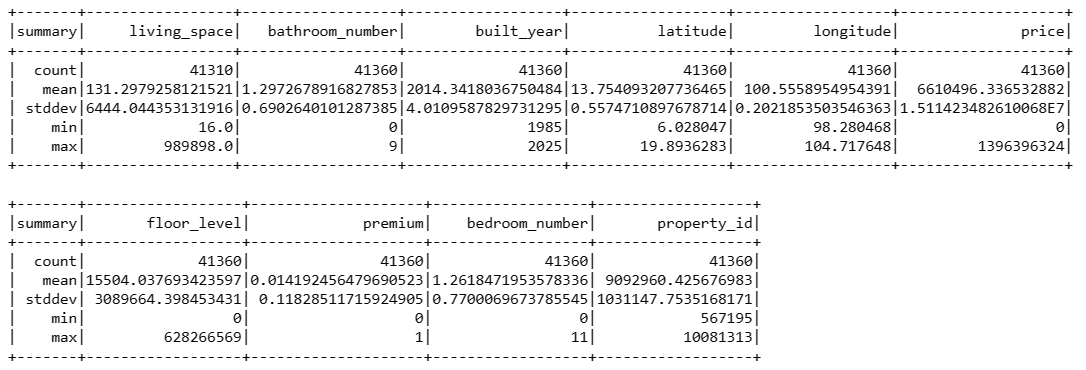
In the preliminary exploration, it is noticed that there are a total of 18 columns, with a variety of data types (string, double, int). Upon further analysis with .describe() of the numerical features, providing an overview of their count, mean, standard deviation, minimum and maximum value.

Then, .count() was also used, to inspect the unique values of each feature.

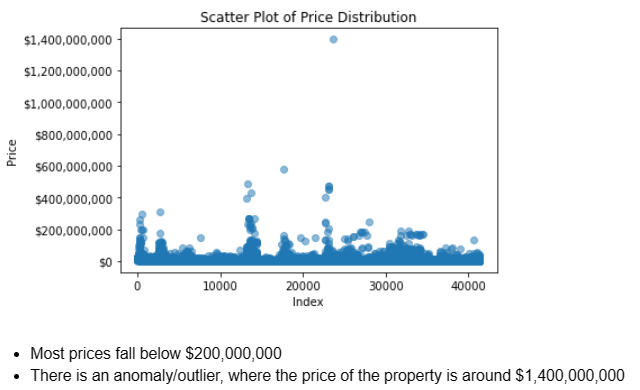

In this scatterplot of the target variable, while most of the values fall at the bottom, there is a property with a much higher price, which is an outlier.

These preliminary exploring gives a clearer picture of the data, and guides how the EDA portion should be. (230 words)

### 2. Exploratory Data Analysis and Data Cleansing 
- Interesting Trends 
- Anomalies 
- Potential Errors 
- Missing Value Treatment

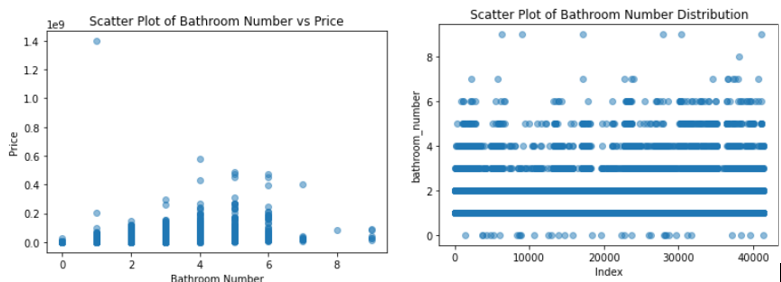
From the numeric features, it can be observed that the most popular number of bathrooms are 1-2, but bathroom number 4-5 seems to have higher prices than the rest. This is interesting as most would expect the popular bathrooms to be more expensive. 

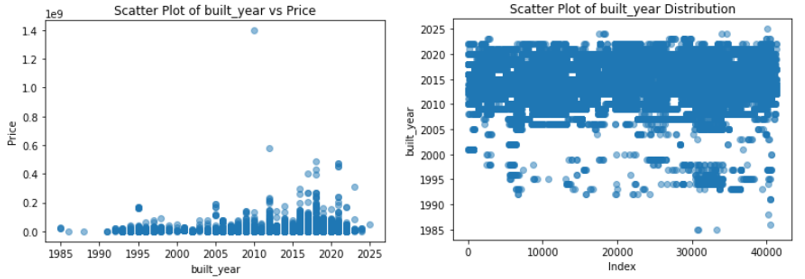

Excluding the price outlier, it is notable that the prices increase as the year goes by. The price seems peak at around 2018. However, it is interesting that prices for 2022-2025 dropped.

It is noticeable that most houses were build around 2010-2021, and the number of houses built started slowing down. It is interesting to note that there is a clutter of houses built around 1995 period.

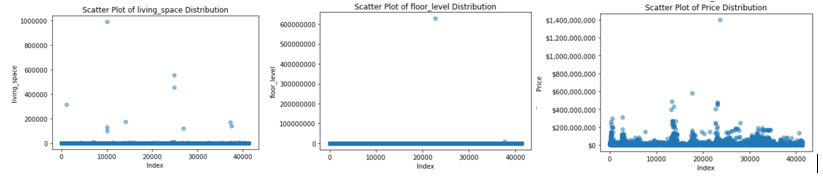

These 3 features have very obvious anomalies/outliers that would be taken care of during outlier handling later. Although it is possible for the living space and price to be that high, it is very rare, and hence are considered outliers. As for floor level, it would be considered an error as it is not possible for floor levels to be that high. 

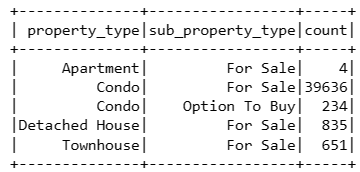

This is interesting as it can be observed that Apartment, Detached house, and Townhouse only has sub_property_type "For Sale". Condo is the only property with "For Sale" and "Option to buy". Condos also seems to be the most popular.

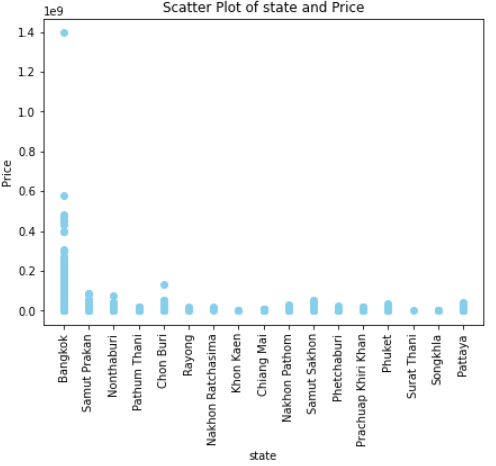

It seems that the prices of properties in Bangkok are alot higher than the other states. This may be due to the fact that Bangkok is the capital of Thailand, causing prices there to rise.

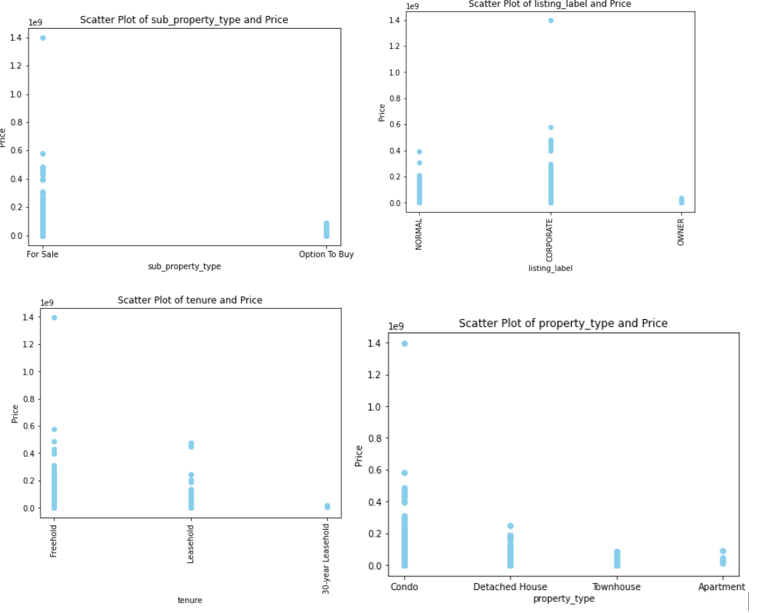

Through analysis of some features against price, it is notable that for sale, corporate, freehold and condo, are the categories with the highet price in their own respective features.

This concludes the EDA, and here we start cleaning the data to prepare the data for transforming.

Next, columns 'property_id','currency','latitude','longitude', and 'address' are dropped as they are unnecessary and will not be meaningful for the prediction, even after transformation.

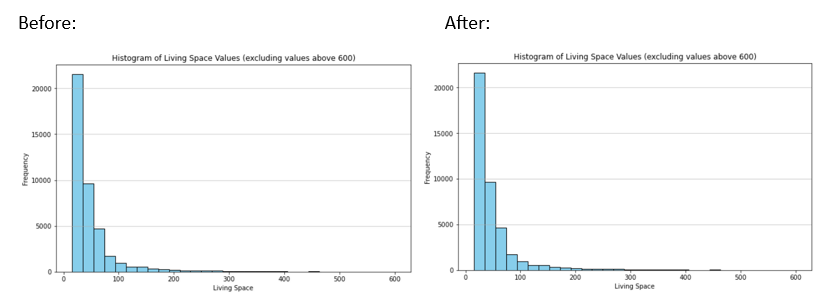
As 'living_space' contains null values,to keep the shape of the heavily right skewed histogram, median was used to impute. Median is also less sensitive to extreme values. (340 words)

### 3. Data Wrangling and Transformation 
- Categorical Data 
- Numerical Data 
- Others 

A new column, 'property_age' was created from built_year. 

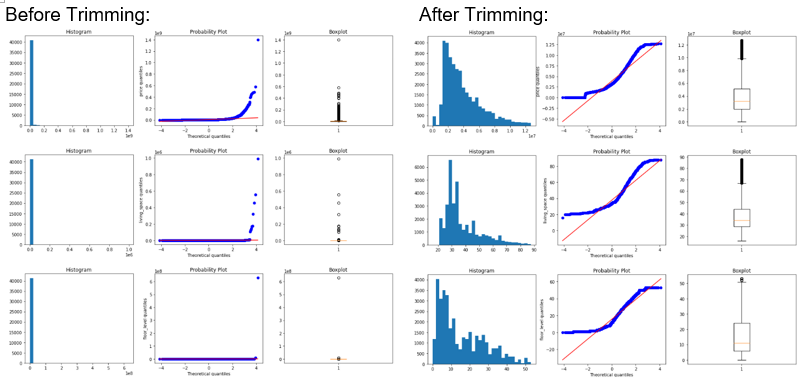

Before moving on to transformations, some outliers/anomalies highlighted in EDA needs to be handled. Trimming was used. Trimming involves removing extreme values (outliers) from a dataset. It reduces the impact of extreme values on mean and standard deviation, addressing skewness-related distortions in modeling. It also mitigates the sensitivity to outliers, leading to more reliable and less biased predictions. With the help of QQ-plots, as the probability plot became steeper and aligns more closely with the best fit line after trimming, it proves that the data is now better aligned, potentially leading to improved model performance.

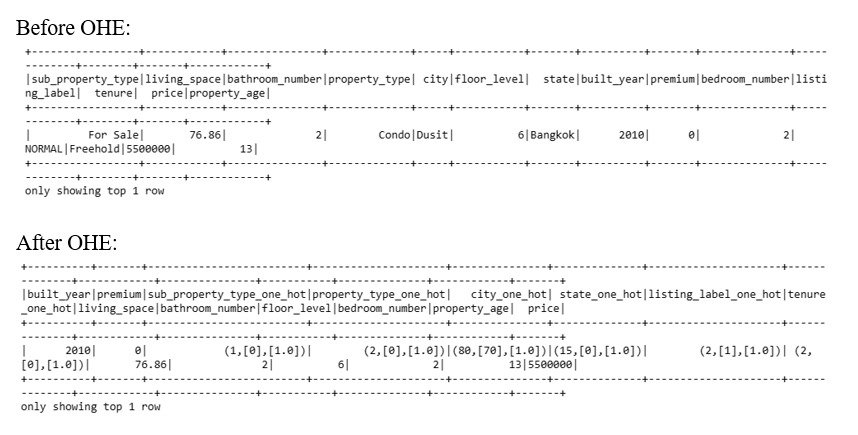
All categorical features are transformed using One-Hot-Encoding with PySpark Pipeline. One-Hot-Encoding is able to transform categorical variables into a binary vector representation, allowing models to process and learn from categorical information effectively. It ensures that the encoded features remain independent. By employing One-Hot-Encoding within a PySpark Pipeline, it adhere to best practices for handling categorical data in machine learning, and leverages the capabilities of PySpark for efficient and scalable data processing.

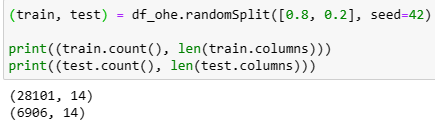

Train test split was done next, where it is split by 80/20. Splitting like this ensures that the train data learns enough data so that the test data is able to make realistic predictions

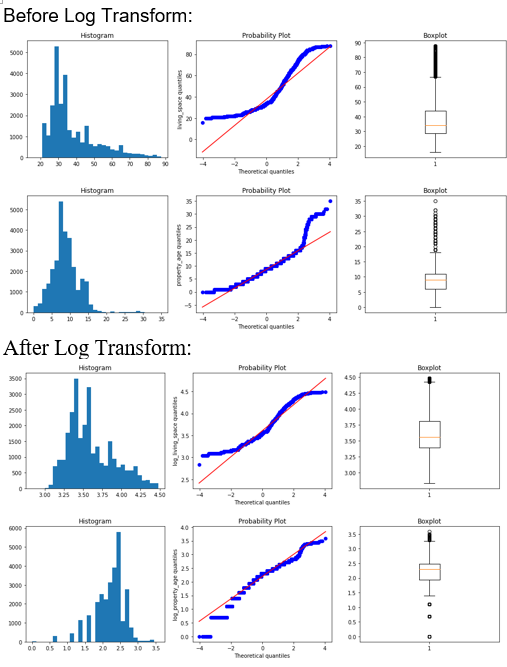
Only property age and living space are transformed. Discrete features do not need transformation as the values are meaningful and ordered. 

Here, Log Transformation was applied as it is able to reduce the skewness of the right skewed features. Yeo-Johnson was also tried and tested, however, the metrics for the Linear Regression Model became worse.

Similar to handling outliers, when more values fall on the best fit line and the best fit line becomes steeper, it proves that this method improved it.

After transformations, X columns were consolidated and Standard Scalar was applied to scale all numerical values to the same scale. Then, it is ready for modelling. (316 words)

### 4. Machine Learning Modelling 
- Show Count of Rows and Columns 
- Sample of 10 Rows before Modelling 
- Build the Predictive Model 

This is where we build the models for our dataset. For this prediction, Linear Regression Model and Random Forest Model were chosen to be the Predictive Algorithm Models. 

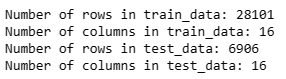

Before modelling, inspection of the final data will be done first, to ensure everything is done correctly. Here, it shows the total number of rows and columns for the train and test data.

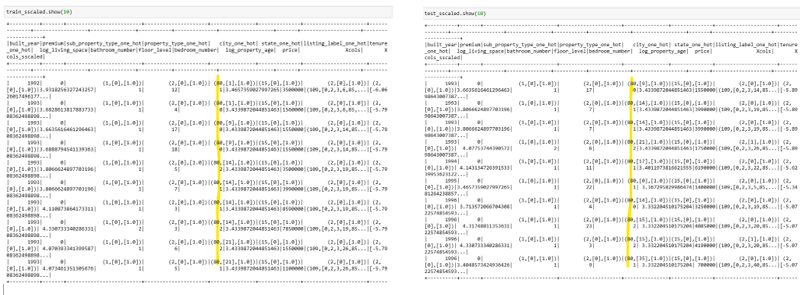

By looking at the individual rows, it is noticed that the numeber of vectors match for both test and train (highlighted). It is important for both train and tests' vectors to be the same number, otherwise the model evaluation and metrics would not be able to work. Since they match and everything seems okay, this is where the models are built. It is also important to note that the target variable should not be touched after outlier handling, so that it does not interfere with the model results. (150 words)

### 5. Model Evaluation and Selection  
- Utilize Model Metrics for Evaluation 
- Compare Models and Decide on Final Model 

Here, the predictions of Linear Regression is analysed, and most importantly, the metrics of MAE, MSE and r^2 of both Linear Regression and Random Forest are calculated to check the accuracy of the model. And therefore, decide on the final model that works best on the dataset. These metrics serve as crucial indicators of how well the models perform in terms of predicting the target variable.

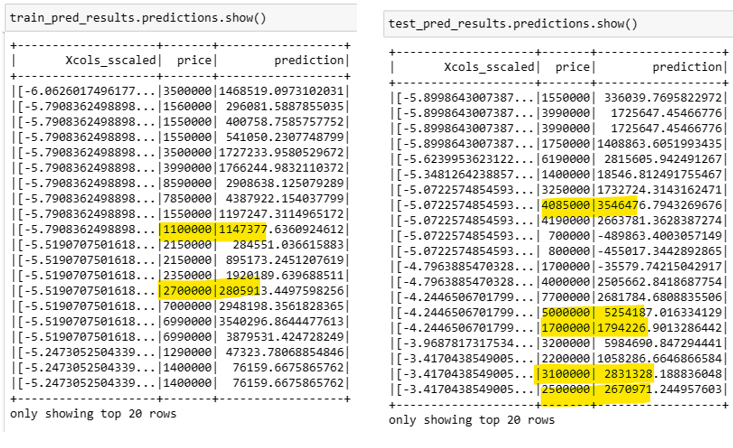

This are the predictions of Linear Regression. The highlighted ones are values that were well predicted. 

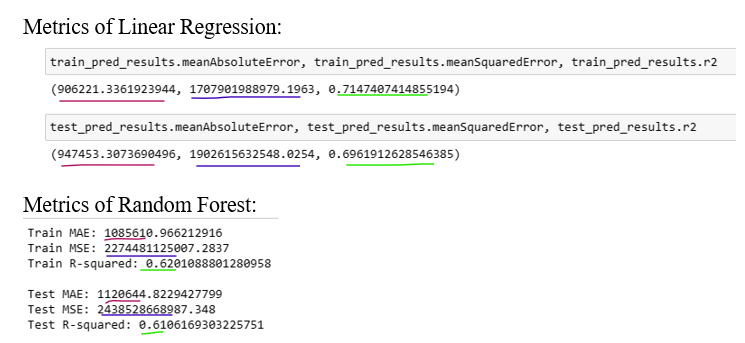

The lower value of MAE and MSE implies higher accuracy of a regression model, and a higher value of R square implies higher accuracy. 

Upon careful examination, the results consistently favor the Linear Regression model. The lower MAE and MSE values obtained from the Linear Regression predictions highlight its ability to make more precise predictions, capturing the nuances of the data with smaller errors. Additionally, the higher R-squared value for the Linear Regression model indicates a greater proportion of variance explained, suggesting a superior overall fit to the dataset compared to the Random Forest model.

As the combination of lower MAE and MSE values, along with a higher R-squared value, indicates a more accurate and better-fitting model for Linear Regression,  the Linear Regression model is chosen as the final model. 

The thorough analysis of model predictions and metrics not only underscores the effectiveness of the Linear Regression model but also provides a clear and well-supported rationale for its selection as the final model for making accurate predictions on the given dataset. (253 words)

### 6. Summary and Further Improvements 
- Summarize your findings 
- Explain the possible further improvements  

Summary:
    
In summary, the comprehensive analysis and modeling of the Thailand property dataset revealed key insights. Notably, Linear Regression outperformed Random Forest, displaying lower MAE and MSE values, indicative of superior prediction accuracy. The higher R-squared value reinforced the Linear Regression model's better overall fit to the data. Intriguing trends, such as the impact of bathroom numbers on prices and the fluctuation in property prices over the years, were identified during exploratory data analysis. The data cleansing process effectively handled outliers, and the strategic use of transformations, including One-Hot-Encoding and Log Transformation, enhanced model performance. The chosen Linear Regression model emerged as the optimal predictor for Thailand property rental prices.

Improvements:

Here, I train test split was done after categorical encoding because I was unable to fix a problem I was facing if I did the train test split before categorical encoding. Although the model turned out decent, I feel like it would be better if i was able to split in front, as it makes more sense as well, for machine learning. It will avoid possible data leakage as well.

Additionally, I could use a wider range of models so that I can find out which model truly suits this prediction the best. 

I could have also experimented with more methods of transformation to see how I can improve my model metrics further. (224 words)